# Airline Review Sentiment Analysis
***
**Author:** Ron Lodetti Jr.
![airplane](./images/airplane.jpg)

## Overview
***
In this project, we aimed to enhance customer sentiment and loyalty for a popular airline by analyzing over 20,000 historical customer reviews. The primary challenge lay in identifying the most impactful factors on customer satisfaction from a broad dataset, leading to a focus on Natural Language Processing (NLP) to predict customer recommendations accurately.

The preparation phase involved train-test splits to prevent data leakage, punctuation removal, and conversion of reviews to lowercase to standardize the data. For Bag-of-Words models, we lemmatized reviews and created a TF-IDF matrix, selecting the 20,000 most relevant word vectors. Sequential models involved converting reviews into sequence vectors and using GloVe embeddings for an embedding matrix. This approach ensured our models could accurately interpret the nuanced language of customer reviews.

We tested a broad range of models, beginning with a dummy classifier and basic logistic regression for baseline comparisons. Our exploration included both Bag-of-Words and Sequential models, leveraging packages like Scikit-learn for logistic regression, MultinomialNB, GradientBoostingClassifier, RandomForestClassifier, and Keras for Recurrent Neural Networks (RNN) with GloVe embeddings. The choice of models was guided by the need to accurately capture the sentiment expressed in textual reviews, with parameter tuning done using RandomizedSearchCV.

The final model is a Multi-Layer Percceptions model that achieved a 92% accuracy and 97% AUC on a previously unseen test set. We then used Local Interpretable Model-Agnostic Explanations (LIME) to uncover the strong influence of punctuality and kind customer service. 

In [1]:
import os
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from lime.lime_text import LimeTextExplainer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import RegexpTokenizer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from tensorflow.data import AUTOTUNE as tf_AUTOTUNE, Dataset as tf_Dataset
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, GRU, TextVectorization
from tensorflow.keras.models import Sequential

from src import code

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging (1: INFO, 2: WARNING, 3: ERROR)
warnings.filterwarnings('ignore')  # Suppress Python warnings

tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")

2024-04-10 23:37:23.842271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Business Problem
***
A popular airline company wants to increase customer sentiment and foster loyalty through improving customer service. Some difficulties include the many different areas the company could focus on, such as flight attendant training, food quality, seat comfort, as well as the challenge of manually reviewing survey data.

The airline has tasked me with analyzing over 20,000 historical reviews to help predict customer satisfaction and identify the most influential features responsible for customer satisfaction.

By creating a predictive model to analyze customer sentiment at scale, our project aims to provide the airline with the insights needed to make informed decisions, ultimately improving the customer experience, fostering loyalty, and enhancing the brand's competitive edge in the market.

## Data Understanding

The original dataset was collected from from [airlineequallity.com](https://www.airlinequality.com/review-pages/a-z-airline-reviews/) by 
Juhi Bhojani. You can find more details about their collection process at their [GitHub](https://github.com/Juhibhojani/Airline-Reviews-). I found and downloaded the data directly from [Kaggle](https://www.kaggle.com/datasets/juhibhojani/airline-reviews) in the form of a csv. 

While originally including 20 columns, I decided to select just 3 of them to focus this project on Natual Language Processing. The `Review_Title` and `Review` columns will be combined to serve as the review texts and the target will be the `Recommended` column which consists of either "yes" or "no". 

In [2]:
# Load the dataset, selecting only relevant columns
df = pd.read_csv('data/Airline_review.csv')[['Review_Title', 'Review', 'Recommended']]

df.head()

Review_Title  \
0                "pretty decent airline"   
1                   "Not a good airline"   
2         "flight was fortunately short"   
3    "I will never fly again with Adria"   
4  "it ruined our last days of holidays"   

                                              Review Recommended  
0    Moroni to Moheli. Turned out to be a pretty ...         yes  
1   Moroni to Anjouan. It is a very small airline...          no  
2    Anjouan to Dzaoudzi. A very small airline an...          no  
3    Please do a favor yourself and do not fly wi...          no  
4   Do not book a flight with this airline! My fr...          no

23,171 Reviews with no missing components. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review_Title  23171 non-null  object
 1   Review        23171 non-null  object
 2   Recommended   23171 non-null  object
dtypes: object(3)
memory usage: 543.2+ KB


Combining title and review to include any important information in the titles of reviews. Then I use a custom function to normalize the reviews.

In [4]:
df['reviews'] = df['Review_Title'] + ' ' + df['Review']

tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")

df['clean_review'] = code.preprocess_texts(df['reviews'], tokenizer, stop_words= False, lemmatize= False)
df['clean_review'].head()

0    pretty decent airline moroni to moheli turned ...
1    not a good airline moroni to anjouan it is a v...
2    flight was fortunately short anjouan to dzaoud...
3    i will never fly again with adria please do a ...
4    it ruined our last days of holidays do not boo...
Name: clean_review, dtype: object

Notice the imbalance target variable with almost 2/3 being "no" recommendations.

In [5]:
# Number and distribution of target
display(df['Recommended'].value_counts())
print('')
display(df['Recommended'].value_counts(normalize=True))

Recommended
no     15364
yes     7807
Name: count, dtype: int64

Recommended
no     0.66307
yes    0.33693
Name: proportion, dtype: float64

In [6]:
# Preparing the data for word and character analysis
df['tokens'] = df['clean_review'].apply(lambda x : x.split())
df['word_count'] = df['tokens'].apply(lambda x: len(x))
df['char_count'] = df['clean_review'].apply(lambda x: len(x))

# Separating dataframes based on Recommendation
yes_df = df.loc[df['Recommended']=='yes'].copy()
no_df = df.loc[df['Recommended']=='no'].copy()

"No" reviews contain slighly more words than "Yes" reviews in general. 

In [7]:
print("Average Number of Words per Review")
print('Yes Reviews: ',yes_df['word_count'].median())
print('No Reviews: ',no_df['word_count'].median())

Average Number of Words per Review
Yes Reviews:  86.0
No Reviews:  117.0


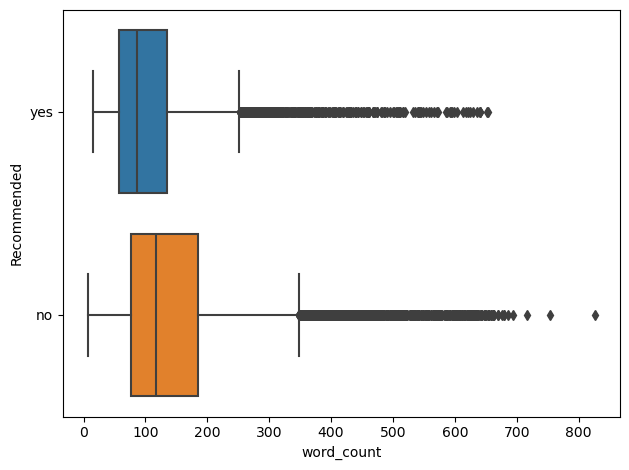

In [8]:
sns.boxplot(data=df, x='word_count', y='Recommended', hue='Recommended',dodge=False)
plt.legend().remove()
plt.tight_layout()
plt.show()

As expected, "No" reviews are also longer on average. 

In [9]:
print("Average Review Length")
print('Yes Reviews: ',yes_df['char_count'].median())
print('No Reviews: ',no_df['char_count'].median())

Average Review Length
Yes Reviews:  475.0
No Reviews:  628.0


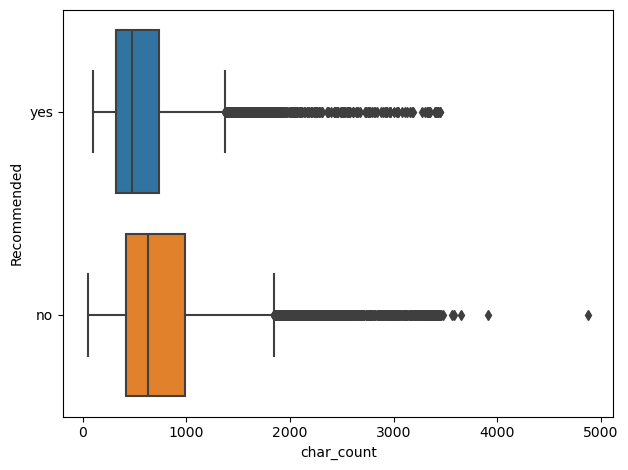

In [10]:
sns.boxplot(data=df, x='char_count', y='Recommended', hue='Recommended',dodge=False)
plt.legend().remove()
plt.tight_layout()
plt.show()

Now I want to see the most common words between Yes and No reviews.

In [11]:
# Combining tokens into two long lists
yes_tokens = yes_df['tokens'].explode()
no_tokens = no_df['tokens'].explode()

# Counting frequencies of words
freq_yes = Counter(yes_tokens)
freq_no = Counter(no_tokens)

# Extracting top 10 most frequent word by category
top_yes_words = freq_yes.most_common(10)
top_no_words = freq_no.most_common(10)

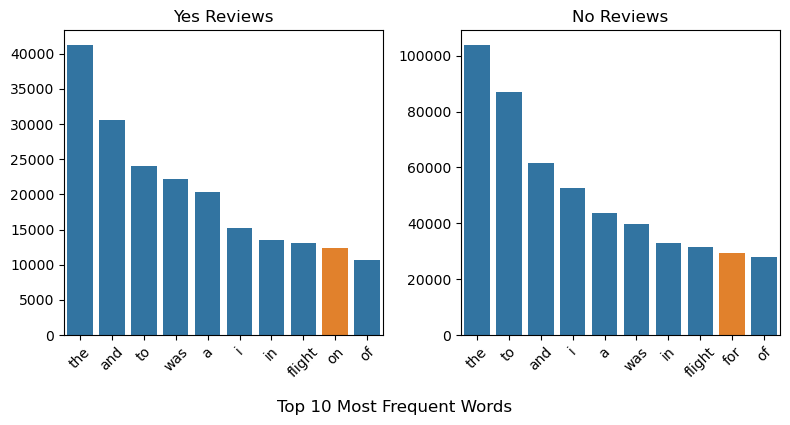

In [12]:
code.most_common_words(top_yes_words, top_no_words)

Well this isn't very informative. Let's lemmatize and remove stop words.

In [13]:
STOPWORDS = stopwords.words('english')
STOPWORDS.append("us")
STOPWORDS.append("u")
# Combine title and review, then preprocess and tokenize
df['stopped_tokens'] = code.preprocess_texts(df['clean_review'],
                                             tokenizer, 
                                             stop_words=STOPWORDS, 
                                             lemmatize=True, 
                                             tokenize=True)

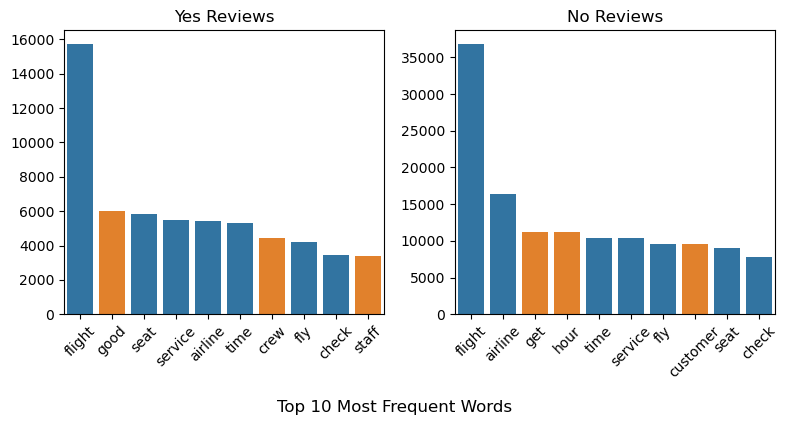

In [14]:
# Split based on recommendation
yes_tokens_stopped = df.loc[df['Recommended'] == 'yes', 'stopped_tokens'].explode()
no_tokens_stopped = df.loc[df['Recommended'] == 'no', 'stopped_tokens'].explode()

# Calculate frequencies
freq_yes_stopped = Counter(yes_tokens_stopped)
freq_no_stopped = Counter(no_tokens_stopped)

# Get the most common terms
top_yes_words_stopped = freq_yes_stopped.most_common(10)
top_no_words_stopped = freq_no_stopped.most_common(10)

# Display top words
code.most_common_words(top_yes_words_stopped, top_no_words_stopped)

Better, but they still share too many of the same words. Next I'll, subtract word frequencies between each other to find the most common distinct words in each set. 

First, let's scale the no word frequencies counter as there are about double the number of No reviews as yes reviews. This will still preserve the distribution within each set. 

In [15]:
# scaling the no word frequencies
freq_no_scaled = Counter({word: round(count / 2) for word, count in freq_no_stopped.items()})

# Subtracing frequencices to highlight distict words in each set. 
distinct_yes = freq_yes_stopped - freq_no_scaled
distinct_no = freq_no_scaled - freq_yes_stopped

top_distinct_yes = distinct_yes.most_common(10)
top_distinct_no = distinct_no.most_common(10)

Top "Yes" words are are generally positive connotations, with "good" occurring almost twice as often as any other word. 

While the top "No" words have to do with time, noticing "hour", "never", "delay", "day". They are also pretty equally distributed. 

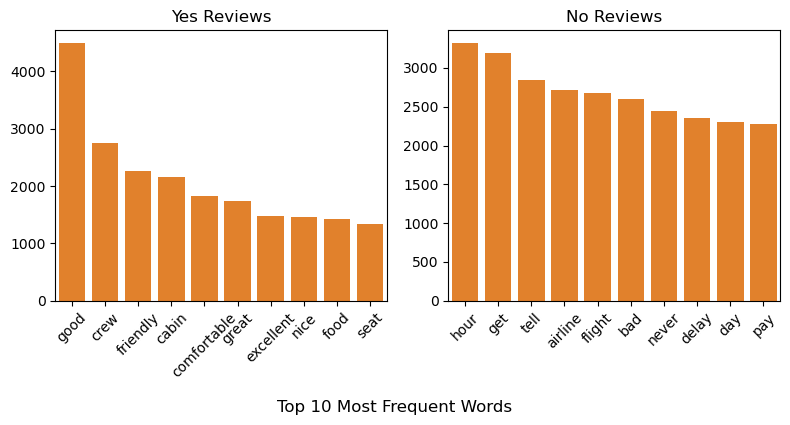

In [16]:
code.most_common_words(top_distinct_yes, top_distinct_no)

## Data Preparation
***

Preparation began by creating train-test splits to prevent data leakage. I then cleaned the data by removing punctuation and converting all reviews to lowercase. From there, data prep diverged based on the type of model being used.

Bag-of-Words models:
- Lemmatized the reviews
- Created a data processing pipeline which includes:
    - Converting reviews to a TF-IDF maxtrix
    - Selecting the 20,000 most relevant word vectors

Sequantial models:
- Converted reviews into sequence vectors
- Created an embedding matrix using pre-trained GloVe embeddings.

In [17]:
# Combine 'Review_Title' and 'Review' for a unified text feature
X = df['Review_Title'] + ' ' + df['Review']

# Converting target column to binary
y = df['Recommended'].map({'yes': 1, 'no': 0})

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.1,  # Reserve 10% of the data for testing
    stratify=y,  # Ensure the training and test sets have similar distributions of responses
    random_state=42  # Seed for reproducibility
)

### Bag of Words Prep

In model testing, lemmatizing text without removing stop words consistently yielded higher accuracy scores.

In [18]:
# Cleaning and lemmatizing training and testing sets. 
X_train_bow = code.preprocess_texts(X_train, tokenizer, stop_words=None, lemmatize=True)
X_test_bow = code.preprocess_texts(X_test, tokenizer, stop_words=None, lemmatize=True)

# Initialize a TF-IDF Vectorizer for transforming text data into numerical data
tf_idf = TfidfVectorizer(
    decode_error='replace',    
    strip_accents='unicode',   
    stop_words=None,           # Not removing stop words
    ngram_range=(1, 2),        # Using unigrams and bigrams
    max_df=0.95,               # Ignoring terms with a document frequency higher than 95%
    min_df=2                   # Ignoring terms with a document frequency lower than 2
)

# Selecting the 20,000 Best features
k_best = SelectKBest(k=20000)

# Creating a pipeline for data preprocessing
bow_pipe = Pipeline([
    ("tf_idf", tf_idf),
    ('feature_selection', k_best)
])

# Transform the training and test sets using the Bag of Words pipeline
X_train_bow_transformed = bow_pipe.fit_transform(X_train_bow, y_train)
X_test_bow_transformed = bow_pipe.transform(X_test_bow)

For the MLP model, preprocessing included creating a validation dataset and converting the pipeline output to a TensorFlow Dataset for improved processing speed.

In [19]:
# Making a validation dataset.
X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(
    X_train_bow_transformed, y_train, 
    test_size=0.1,  # Reserve 10% of the data for validation
    stratify=y_train,  # Stratify split based on the labels to ensure balanced classes
    random_state=42  
)

# Prepare TensorFlow datasets for training, validation, and testing phases
# Convert sparse matrix to dense format for compatibility with TensorFlow
mlp_train_ds = code.prepare_tf_dataset(X_train_mlp.todense(), y_train_mlp, 256, is_training=True)
mlp_val_ds = code.prepare_tf_dataset(X_val_mlp.todense(), y_val_mlp, 256)
mlp_test_ds = code.prepare_tf_dataset(X_test_bow_transformed.todense(), y_test, 256)

### Sequential Model Prep
To preserve the integrity of sequential text information, I opted against removing stop words and lemmatization. A sequence length of 200 was selected, accounting for over 80% of reviews falling below this threshold, a decision validated during model testing. As with the MLP model, the final steps included creating a validation set for model fitting and converting datasets to TensorFlow Datasets for efficiency.

In [20]:
# Preprocess text data for sequence models
X_train_seq = code.preprocess_texts(X_train, tokenizer)
X_test_seq = code.preprocess_texts(X_test, tokenizer)

# Initialize TextVectorization for converting text to sequences of integers
text_vectorization = TextVectorization(
    standardize=None,  # Not needed as already cleaned in previous step.
    max_tokens=20000,  # Maximum vocab size
    output_mode='int', 
    output_sequence_length=200  # Fixed length of output sequences
)

# Making a validation dataset to use when fitting RNN and GloVe models.
X_train_seq_split, X_val_seq_split, y_train_seq_split, y_val_seq_split = train_test_split(
    X_train_seq, y_train, 
    test_size=0.1, 
    stratify=y_train, 
    random_state=42  
)

# Learning and creating the vocabulary for the training set
text_vectorization.adapt(X_train_seq_split)

# Transforming text data into integer sequences based on learned vocabulary
X_train_seq_transformed = text_vectorization(X_train_seq_split)
X_val_seq_transformed = text_vectorization(X_val_seq_split)
X_test_seq_transformed = text_vectorization(X_test_seq)

# Prepare TensorFlow datasets for training, validation, and testing
seq_train_ds = code.prepare_tf_dataset(X_train_seq_transformed, y_train_seq_split, 256, is_training=True)
seq_val_ds = code.prepare_tf_dataset(X_val_seq_transformed, y_val_seq_split, 256)
seq_test_ds = code.prepare_tf_dataset(X_test_seq_transformed, y_test, 256)

Lastly, I set up the GloVe pretrained embedding layer by loading the file and including only vectors from the training set's vocabulary.

In [21]:
# Retrieve the vocabulary from the text vectorization layer
vocabulary = text_vectorization.get_vocabulary()
vocab_size = len(vocabulary)  # Determine the size of the vocabulary

# Initialize a dictionary to store GloVe embeddings
glove_embeddings = {}

# Read the GloVe embeddings file and creating glove_embeddings dictionary with word vectors
with open('data/glove.6B.300d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]  # Extract the word
        vector = np.asarray(values[1:], dtype='float32') 
        glove_embeddings[word] = vector 

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, 300))  # 300 dimensions for GloVe vectors

# Populate the embedding matrix with vectors from GloVe, matching our vocabulary words
for i, word in enumerate(vocabulary):
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


## Data Modeling
***

Modeling began by using a dummy classifier and a basic logistic regression model as a baseline to compare to later. I then tested a number of models, gridsearching for optimal parameters. 

**Modeling Overview:**

Baseline Models
- Dummy Classifier
- Logistic Regression (Basic)

Bag-of-Words Models
- Logistic Regression
- MultinomialNB
- GradientBoostingClassifier
- RandomForestClassifier
- Multi-Layer Perceptrons (MLP)

Sequential Models
- Recurrent Neural Network (RNN)
- RNN with GloVe Pretrained Embedding Layer

### Baseline Models

Given the target class imbalance, I chose to include a dummy model in addition to a simple model to compare future models against. 

In [22]:
# Instantiating the baseline models
dummy_model = DummyClassifier(strategy='uniform', random_state=42)
baseline_model = LogisticRegression(max_iter=1000)

# Fitting the models on the training data
dummy_model.fit(X_train_bow_transformed, y_train)
baseline_model.fit(X_train_bow_transformed, y_train)

# Loading previously saved cross-validation scores
pd.read_pickle('data/saved_models/model_scores_df.pkl').iloc[:2, :]

Model  Accuracy      AUC
0     Dummy  0.499832  0.50000
1  Baseline  0.905481  0.96144

### Bag of Words Models

In [23]:
# Instantiating models with parameters derived from RandomizedSearchCV
log_reg = LogisticRegression(C=9.42012179027564, max_iter=100, solver='newton-cg')

mnb_model = MultinomialNB(fit_prior=False, class_prior=None, alpha=0.01)

gbc_model = GradientBoostingClassifier(
    subsample=0.8, n_estimators=300, min_samples_split=2,
    max_features='sqrt', max_depth=6, learning_rate=0.1
)
rfc_model = RandomForestClassifier(
    n_estimators=500, min_samples_split=10, min_samples_leaf=1,
    max_features='sqrt', max_depth=None, bootstrap=True
)
pd.read_pickle('data/saved_models/model_scores_df.pkl').iloc[2:6, :]

Model  Accuracy       AUC
2           Logistic_Regression  0.916031  0.967635
3                 MultinomialNB  0.887738  0.948371
4  Gradient_Boosting_Classifier  0.902220  0.958531
5      Random_Forest_Classifier  0.886971  0.949088

In [24]:
# Define a list of callbacks for the training process
CALLBACKS = [
    EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        min_delta=0.001,  # Minimum change to qualify as an improvement
        patience=5,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
        verbose=0  # Do not output verbose messages
    )
]
# Defining a Multilayer Perceptron (MLP) model for binary classification
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(20000,)), # input_shape to match SelectKBest 
    Dropout(0.8),
    Dense(1, activation='sigmoid')
])

# Compiling the model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Fitting the model on the training dataset while validating on a separate dataset
mlp_model.fit(mlp_train_ds, validation_data=mlp_val_ds, epochs=100, verbose=0, callbacks=CALLBACKS)

pd.read_pickle('data/saved_models/model_scores_df.pkl').iloc[6:7, :]

Model  Accuracy       AUC
6   MLP  0.917915  0.969525

### Sequential Models

In [25]:
# Defining a RNN model 
rnn_model = Sequential([
    # input_dim to match max_tokens
    # input_length to match sequence_length
    Embedding(input_dim=20000, output_dim=32, input_length=200), 
    # Bidirectional GRU to capture context in both directions
    Bidirectional(GRU(16)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
rnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])

# Commenting out below to save run time.
# rnn_model.fit(seq_train_ds,
#               validation_data=seq_val_ds,
#               batch_size=256,
#               epochs=100,
#               verbose=0, 
#               callbacks=CALLBACKS,
#               shuffle=True) 
pd.read_pickle('data/saved_models/model_scores_df.pkl').iloc[7:8, :]

Model  Accuracy       AUC
7   RNN  0.890759  0.951667

In [26]:
# Defining a model leveraging pre-trained GloVe embeddings
glv_model = Sequential([
    # Embedding layer with pre-trained GloVe weights, set to non-trainable to retain pre-trained knowledge
    # input_dim to match vocab_size derived from text_vectorization layer
    Embedding(input_dim=vocab_size, output_dim=300, input_length=200, weights=[embedding_matrix], trainable=False),
    Bidirectional(GRU(32)),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Compiling the model
glv_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])

# Commenting out below to save run time.
# glv_model.fit(seq_train_ds,
#               validation_data=seq_val_ds,
#               batch_size=256,
#               epochs=100,
#               verbose=0, 
#               callbacks=CALLBACKS,
#               shuffle=True)

pd.read_pickle('data/saved_models/model_scores_df.pkl').iloc[8:, :]

Model  Accuracy      AUC
8  GloVe  0.909557  0.96396

After model iteration and parameter searching, the MLP model scored the best with an accuracy of 91.79% and AUC of 96.95% on validation data. This was closely followed by the Logistic Regression and GloVe models. 

## Evaluation
***
Our final model was evaluated on a previously unseen test dataset to assess its performance in classifying reviews as either "Yes" or "No". The model demonstrated an accuracy of 92%, which represents a modest improvement over our baseline model's accuracy of 90.8%. This performance is substantially superior to that of the dummy model, which had an accuracy of only 50%.

This increase in accuracy, while seemingly small, is critical in the context of our project's objectives. It underscores the effectiveness of the chosen model and techniques in capturing the nuances of the data that were not as effectively addressed by the baseline model. Additionally, the comparison with the dummy model, which makes predictions based on no information about the data, highlights the value added by our modeling approach.

In [27]:
# Evaluating models and storing their scores
dummy_scores = code.evaluate_model(dummy_model, X_test_bow_transformed, y_test)
baseline_scores = code.evaluate_model(baseline_model, X_test_bow_transformed, y_test)
mlp_scores = mlp_model.evaluate(mlp_test_ds, verbose=0)

# Creating a dictionary to hold models and their respective scores
models_dict = {
    'Dummy Model': dummy_scores,
    'Baseline Model': baseline_scores,
    'Final Model': mlp_scores[1:]  # Dropping loss score
}

# Collecting scores in a list
scores_list = [scores for scores in models_dict.values()]

# Creating a DataFrame from the scores list
summary_df = pd.DataFrame(scores_list, 
                          columns=['Test Accuracy', 'Test AUC'], 
                          index=models_dict.keys())

# Displaying the summary DataFrame
display(summary_df)

Test Accuracy  Test AUC
Dummy Model          0.499569  0.500000
Baseline Model       0.908110  0.963018
Final Model          0.919327  0.967637

### Model Interpretation
Now I will use LIME to see which words were the most influential for recommendations

In [28]:
# Set up LIME Explainer
explainer = LimeTextExplainer(class_names=['No', 'Yes'])

In [29]:
def predict_text_probabilities(texts):
    preprocessed_texts = code.preprocess_texts(pd.Series(texts), tokenizer, 
                                               stop_words=STOPWORDS, lemmatize=True)
    transformed_texts = bow_pipe.transform(preprocessed_texts).todense()
    preds = mlp_model.predict(transformed_texts, verbose=0)
    return np.hstack((1 - preds, preds))

def show_lime_text_explanation(idx):
   
    
    # Display the explanation in a Jupyter Notebook
    return explanation.show_in_notebook(text=True)

Looking at a couple of reviews, here are some words associated with their type of recommendation.

Yes Reviews:
- nice
- early
- professional
- friendly

No Reviews:
- hours
- delayed
- understaffed

In [30]:
idx= 1789
# Generate explanation for a specific instance
explanation = explainer.explain_instance(X_test.iloc[idx],
                                         predict_text_probabilities,
                                         num_features=5)
# Display the explanation in a Jupyter Notebook
explanation.show_in_notebook(text=True)

![1789](./images/1789.jpg)

In [31]:
idx= 1363
explanation = explainer.explain_instance(X_test.iloc[idx],
                                         predict_text_probabilities,
                                         num_features=5)
explanation.show_in_notebook(text=True)

![1363](./images/1363.jpg)

In [32]:
idx= 1731
explanation = explainer.explain_instance(X_test.iloc[idx],
                                         predict_text_probabilities,
                                         num_features=5)
explanation.show_in_notebook(text=True)

![1731](./images/1731.jpg)

## Conclusions
***
### Recommendations
I  recommend that the airline adopts our final model for classifying customer reviews. This tool can enable the continuous monitoring of customer feedback through a live tally of "Yes" and "No" reviews across any desired timeframe, providing valuable insights for enhancing service quality and customer satisfaction.

Our analysis unequivocally shows that punctuality significantly impacts customer satisfaction. Therefore, I suggest the marketing department leverages this finding by orchestrating a campaign that underscores our airline's commitment to timeliness. A possible campaign message could be: "Choose the airline with the fewest delays—because we value your time." Such a strategy not only highlights our strengths but also positions us favorably against competitors with higher instances of delays.

Furthermore, I strongly advise placing a renewed focus on the customer service department, particularly in terms of training and preparedness. It's essential that all staff members are fully informed about the range of accommodations and solutions available to support passengers during challenging situations. 

### Limitations
One of the primary limitations of this project was the decision to exclude certain features from the original dataset in our model development phase. Notably, variables such as Overall_Rating, Route, and Seat_Comfort, among others, were not considered. The exclusion of these features, while simplifying the initial model, may have restricted our ability to capture the full spectrum of factors influencing customer recommendations.
  
### Next Steps
To improve the predictive model and provide deeper insights for the marketing department, I plan to integrate additional features from the initial dataset. I am particularly interested in analyzing specific ratings such as Seat Comfort, Cabin Staff Service, Food & Beverages, Ground Service, and Value for Money. Additionally, I aim to explore potential correlations between departure/arrival locations and flight duration to ascertain their impact on customer satisfaction.

Incorporating these elements will allow for a more sophisticated analysis of customer feedback, potentially revealing hidden patterns and insights. Such discoveries are expected to guide targeted improvements in the airline's services. This comprehensive approach will also deepen our understanding of the primary factors influencing customer satisfaction and recommendation behaviors, enabling the formulation of more accurately targeted strategic interventions.

